In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 2.6MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 358kB 9.7MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 1.0MB 15.9MB/s 
     |████████████████████████████████| 40kB 4.7MB/s 
     |████████████████████████████████| 40kB 5.5MB/s 
     |████████████████████████████████| 92kB 7.1MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 2.6MB 22.5MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Under the Hood: Train a Digit Classifier

For the sake of simplicity, we are just going to try to create a model that can classify any image as a 3 or a 7.

In [149]:
# downoad a sample of MNIST that contains images of 3 and 7
path = untar_data(URLs.MNIST_SAMPLE)

In [150]:
Path.BASE_PATH = path

`ls`, a method added by fastai, returns an object of a special fastai class call `L`.  
It has all the same functionality of Python's built-in `list`, plus a lot more. One of its handy features is that, when printed, it displays the count of items, before listing the items themselves (if there are more than 10 items, it just shows the first few)

In [151]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set).

In [152]:
(path/"train").ls()

(#2) [Path('train/7'),Path('train/3')]

There's a folder of 3s, and a folder of 7s. We saay "3" and "7" are the **labels** (or **targets**) in this dataset.

In [153]:
threes = (path/"train"/"3").ls().sorted()
sevens = (path/"train"/"7").ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

Let's take a look at an image of a handwritten number 3:

(Here we are using the `Image` class from the *Python Imaging Library (PIL)*, which is the most widely used Python package for opening, manipulating, and viewing images.)

In [154]:
im3_path= threes[1]
im3 = Image.open(im3_path)
im3

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a *NumPy array* or a *PyTorch tensor*:

In [155]:
# convert to a numpy array
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [156]:
# convert to a pytorch tensor
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a **Pandas** `DataFrame` to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:



In [157]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[::])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


- The background white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two.

- The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels.

# First Try: Pixel Similarity

First idea: 
1. we find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give us two group averages, defining what we might call the "ideal" 3 and 7. 
2. Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to.

Let's create a tensor containing all of our 3s stacked together. We already know how to create a tensor containing a single image. To create a tensor containing all the images in a directory, we will first use a Python list comprehension to create a plain list of the single image tensors.

In [158]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

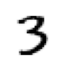

In [159]:
show_image(three_tensors[1])

For every pixel position, we want to compute the average over all the images of the intensity of that pixel.
To do this we combine all the images in this list into a single three-dimensional tensor. Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255.

In [160]:
stacked_sevens = torch.stack(seven_tensors).float() / 255
stacked_threes = torch.stack(three_tensors).float() / 255
stacked_threes.shape

torch.Size([6131, 28, 28])

We can see that we have 6131 images, each of size 28x28 pixels.

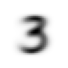

In [161]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

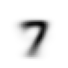

In [162]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

## An End-to-End SGD Example

Let's look at an SGD example and see how finding a minimum can be used to train a model to fit data better.

Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time

In [163]:
time = torch.arange(0, 20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

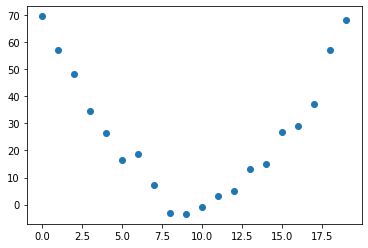

In [164]:
speed = torch.randn(20) * 3 + 0.75 * (time - 9.5) ** 2 + 1
plt.scatter(time, speed)

Question: What was the roller coaster's speed?

Using SGD we can try to find a function that matches our observations. We can't consider every possible function, so let's use a guess that it will be quadratic; i.e., a function of the form `a*(time**2)+(b*time)+c`.

We want to distinguish clearly between the function's input (the time when we are measuring the coaster's speed) and its parameters (the values that define which quadratic we're trying).

In [165]:
def f(t,  params):
    a,b,c = params
    return a * (t ** 2) + (b * t) + c

def mse(preds, targets):
    """
    Use mean squared error as loss function
    """
    return ((preds - targets) ** 2).mean()

### 1. Initialize the parameters

In [166]:
params = torch.randn(3).requires_grad_()
orig_params = params.clone()

### 2. Calculate the predictions

In [167]:
preds = f(time, params)

Create a helper function to see how close our predictions are to our targets:

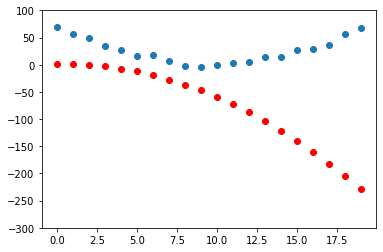

In [168]:
def show_preds(preds, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

show_preds(preds)

### 3. Calculate the loss

In [169]:
loss = mse(preds, speed)
loss

tensor(16887.0645, grad_fn=<MeanBackward0>)

### 4. Calculate the gradients


In [170]:
loss.backward()
params.grad

tensor([-42683.8672,  -2725.1787,   -203.7976])

In [171]:
params.grad * 1e-5

tensor([-0.4268, -0.0273, -0.0020])

In [172]:
params

tensor([-0.6729,  0.6873,  0.9612], requires_grad=True)

### 5. Step the weights

We use these gradients to improve our parametrs. We'll need to pick a learning rate. For now we will just use 1e-5, or 0.00001

In [173]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

Let's see if the loss has improved:

In [174]:
preds = f(time, params)
mse(preds, speed)

tensor(3761.1985, grad_fn=<MeanBackward0>)

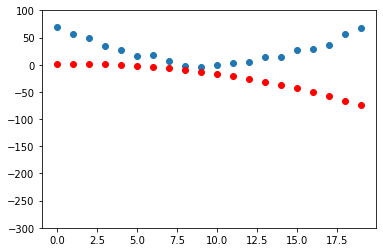

In [175]:
show_preds(preds)

We need to repeat this a few times, so we'll create a function to apply one step:

In [176]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn:
        print(loss.item())
    return preds

### 6. Repeat the process

In [177]:
for i in range(10):
    apply_step(params)

3761.198486328125
1277.3798828125
807.36181640625
718.4161987304688
701.581298828125
698.3917846679688
697.7845458984375
697.6658935546875
697.6397094726562
697.6309814453125


We can see this process visually if, instead of printing out the loss function, we plot the function at every step. Then we can see how the shape is approaching the best possible quadratic function for our data:

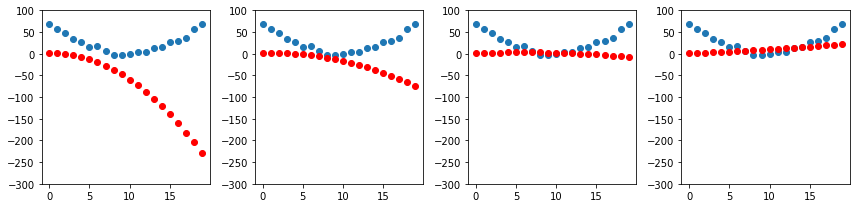

In [178]:
params = orig_params.detach().requires_grad_()

_, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax in axes:
    show_preds(apply_step(params, False), ax)

plt.tight_layout()


### 7. Stop



## The MNIST Loss Function

In [179]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [180]:
train_x.shape

torch.Size([12396, 784])

We need a label for each image. We'll use `1` for 3s and `0` for 7s:

In [181]:
train_y = tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed.

In [182]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

Validation set:

In [183]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [184]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1] * len(valid_3_tens) + [0] * len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we randomly initialize weight for every pixel:

In [185]:
def init_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()

weights = init_params((28*28, 1))

In [186]:
bias = init_params(1)

We can now calcualte a prediction for one image:

In [187]:
(train_x[0] * weights.T).sum() + bias

tensor([5.2001], grad_fn=<AddBackward0>)

In [188]:
def linear1(xb):
    return xb @ weights + bias

preds = linear1(train_x)
preds, preds.shape

(tensor([[  5.2001],
         [ 13.6764],
         [  3.9411],
         ...,
         [  3.2542],
         [-16.3791],
         [ -7.0487]], grad_fn=<AddBackward0>), torch.Size([12396, 1]))

Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.

In [189]:
corrects = (preds > 0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [ True],
        [ True]])

In [190]:
corrects.float().mean().item()

0.6931267976760864

### Sigmoid

The `sigmoid` function always outputs a number between 0 and 1.

In [191]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

Pytorch defines an accelerated version for us, so we don’t really need our own.

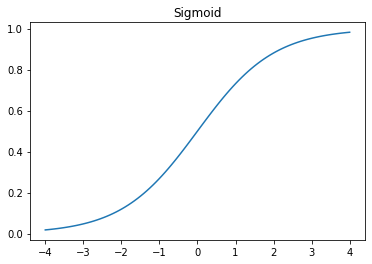

In [192]:
plot_function(torch.sigmoid, title="Sigmoid", min=-4, max=4)

In [193]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for us, called `DataLoader`.

For example:

In [194]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 2,  4, 13,  7, 14]),
 tensor([12,  0,  6, 10,  1]),
 tensor([ 9,  5, 11,  8,  3])]

When we pass a `Dataset` to a `DataLoader` we will get back many batches which are themselves tuples of tensors representing batches of independent and dependent variables:

## Putting It All Together

Our process will be implemented something like this for each epoch:

```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

First, re-initialize our parameters:

In [195]:
weights = init_params((28 * 28, 1))
bias = init_params(1)

Create `DataLoader` from a `Dataset`:

In [196]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

Do the same for the validation set:

In [197]:
valid_dl = DataLoader(valid_dset, batch_size=256)

Create a mini-batch of size 4 for testing:

In [198]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [199]:
preds = linear1(batch)
preds

tensor([[  3.6686],
        [-10.0607],
        [ -2.4094],
        [ -8.2012]], grad_fn=<AddBackward0>)

In [200]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.7355, grad_fn=<MeanBackward0>)

In [201]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0036), tensor([-0.0251]))

Define a function to calculate gradient:

In [202]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [203]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0072), tensor([-0.0501]))

In [204]:
weights.grad.zero_()
bias.grad.zero_();

Our only remaining step is to update the weights and biases based on the gradient and learning rate. 

Note that we have to tell PyTorch NOT to take the gradient of this step! If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step. 

Here's our basic training loop for an epoch:

In [205]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= lr * p.grad
            p.grad.zero_()

We also want to look at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.

In [206]:
(preds > 0.0).float() == train_y[:4]

tensor([[ True],
        [False],
        [False],
        [False]])

In [207]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [208]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)

Put the batches together:

In [209]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [210]:
validate_epoch(linear1)

0.5765

Let's train for one epoch and see if the accuracy improves:

In [211]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7005

Train more epochs:

In [212]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8622 0.9149 0.9354 0.9437 0.9511 0.955 0.9565 0.9594 0.9619 0.9628 0.9643 0.9658 0.9672 0.9692 0.9692 0.9706 0.9721 0.9726 0.9731 0.9736 

### Creating an Optimizer

Create an object that will handle the SGD step for us. In PyTorch, it's called an optimizer.

The first thing we can do is replace our linear1 function with PyTorch's `nn.Linear` module. `nn.Linear` does the same thing as our `init_params` and `linear` together. It contains both the weights and biases in a single class. 

In [222]:
linear_model = nn.Linear(28*28, 1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the `parameters` method:

In [223]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

Create a custom optimizer:

In [224]:
class BasicOptim:

    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr

    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

Now we can create our optimizer by passing the model's parameters:

In [225]:
opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can be simplified to:

In [226]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [227]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(f"epoch {i}: {validate_epoch(model)}")

In [228]:
train_model(linear_model, 20)

epoch 0: 0.4932
epoch 1: 0.7031
epoch 2: 0.8638
epoch 3: 0.9189
epoch 4: 0.9365
epoch 5: 0.9526
epoch 6: 0.959
epoch 7: 0.9644
epoch 8: 0.9668
epoch 9: 0.9683
epoch 10: 0.9712
epoch 11: 0.9727
epoch 12: 0.9741
epoch 13: 0.9751
epoch 14: 0.9761
epoch 15: 0.9766
epoch 16: 0.9775
epoch 17: 0.978
epoch 18: 0.9785
epoch 19: 0.9785


fastai provides the `SGD` class which, by default, does the same thing as our `BasicOptim`:

In [229]:
linear_model = nn.Linear(28 * 28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

epoch 0: 0.4932
epoch 1: 0.8091
epoch 2: 0.8501
epoch 3: 0.9141
epoch 4: 0.9351
epoch 5: 0.9487
epoch 6: 0.958
epoch 7: 0.9624
epoch 8: 0.9663
epoch 9: 0.9683
epoch 10: 0.9697
epoch 11: 0.9717
epoch 12: 0.9736
epoch 13: 0.9746
epoch 14: 0.9761
epoch 15: 0.9771
epoch 16: 0.9775
epoch 17: 0.9775
epoch 18: 0.9785
epoch 19: 0.9785


Instead of `train_model`, we can alos use `Learner.fit` provided by fastai.

To create a `Learner`, we first need to create a `DataLoaders`, by passing in our training and validation `DataLoader`s:

In [234]:
dls = DataLoaders(dl, valid_dl)

To create a `Learner`, we need to pass in all the elements that we've created:
- the `DataLoaders`
- the model
- the optimization function
- the loss function
- metrics to print (optional)

In [235]:
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

Now we call `fit` to train our model:

In [236]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637174,0.502765,0.495584,00:00
1,0.370298,0.290253,0.716879,00:00
2,0.141837,0.152704,0.864082,00:00
3,0.065494,0.096527,0.919529,00:00
4,0.037185,0.072656,0.936212,00:00
5,0.025983,0.059204,0.951423,00:00
6,0.021278,0.050665,0.957802,00:00
7,0.019110,0.044892,0.963690,00:00
8,0.017955,0.040777,0.965653,00:00
9,0.017225,0.037710,0.968106,00:00


As we can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make our life a bit easier!!!

## Adding a Non-linearity

A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.



In [237]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0)) # ReLU
    res = res@w2 + b2
    return res

In [238]:
# Init parameters
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

`res.max(tensor(0.0))` is called a **Rectified Linear Unit (ReLU)**. This function is available in PyTorch as `F.relu`:

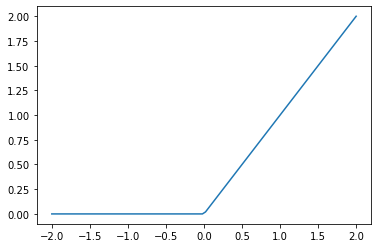

In [239]:
plot_function(F.relu)

we can replace this code with something a bit simpler, by taking advantage of PyTorch:

In [243]:
simple_net = nn.Sequential(
    nn.Linear(28 * 28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

- `nn.Sequential` creates a module that will call each of the listed layers or functions in turn.

- `nn.ReLU` is a PyTorch module that does exactly the same thing as the `F.relu` function. 
    - Most functions that can appear in a model also have identical forms that are modules.
    - When using `nn.Sequential`, PyTorch requires us to use the **module** version. Since modules are classes, we have to instantiate them, which is why we see `nn.ReLU()`

- Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains.

In [245]:
learn = Learner(dls, simple_net, opt_func=SGD, 
                loss_func=mnist_loss, metrics=batch_accuracy)

In [246]:
# As this is a deeper model, 
# we'll use a lower learning rate and a few more epochs.
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.297308,0.417970,0.504907,00:00
1,0.141583,0.222965,0.814033,00:00
2,0.079168,0.112980,0.915113,00:00
3,0.052587,0.076825,0.940137,00:00
4,0.040201,0.060191,0.956820,00:00
5,0.033827,0.050804,0.963690,00:00
6,0.030134,0.044890,0.965162,00:00
7,0.027719,0.040845,0.968106,00:00
8,0.025967,0.037912,0.969578,00:00
9,0.024603,0.035679,0.970069,00:00


The training process is recorded in `learn.recorder`, with the table of output stored in the `values` attribute.

So we can plot the accuracy over training as:

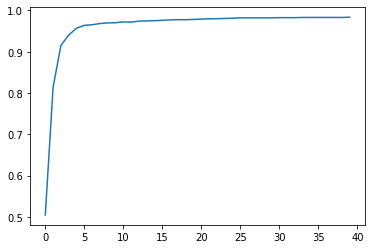

In [248]:
plt.plot(L(learn.recorder.values).itemgot(2));

View the  final accuracy:

In [249]:
learn.recorder.values[-1][2]

0.983316957950592

At this point we have something that is rather magical:

1. A function that can solve any problem to any level of accuracy (the **neural network**) given the correct set of parameters

2. A way to find the best set of parameters for any function (**stochastic gradient descent**)